# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 23.11.2019

Мягкий дедлайн: 8:00MSK 01.12.2019

Жесткий дедлайн: 23:59MSK 02.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.463670910107474

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    N = len(X)
    s = num_runs
    
    all_ind = np.arange(0, N)
    
    loss = np.zeros(N)    # сумма (pred - y_true)^2 для каждого объекта
    Ks = np.zeros(N)      # сколько раз объекто вошел в out-of-bag выборки
    average = np.zeros(N) # sum(preds) / Ks
    squares = np.zeros(N) # sum(preds^2)
    sums = np.zeros(N)    # sum(preds)
    
    for i in range(s):
        indexes = np.random.randint(0, N, N)
        tindexes = np.setdiff1d(all_ind, indexes)

        bX = X[indexes]
        by = y[indexes]
        
        tX = X[tindexes]
        ty = y[tindexes]
        
        algo = regressor.fit(bX, by)
        pred = regressor.predict(tX)
        
        Ks[tindexes] += 1
        average[tindexes] += pred
        sums[tindexes] += pred
        squares[tindexes] += pred ** 2
        
        loss_i = (pred - ty) ** 2
        loss[tindexes] += loss_i
        
        
    average /= Ks
    bias = np.square(average - y).mean()
    var = (squares / Ks - np.square(average)).mean()
    loss /= Ks
    err = loss.mean()
    
    return bias, var, err
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.simplefilter("ignore")

In [24]:
print('Linear Regression\nBias = %f\nVariance = %f\nError = %f\n' % compute_biase_variance(LinearRegression(), X, y))
print('Decision Tree\nBias = %f\nVariance = %f\nError = %f\n' % compute_biase_variance(DecisionTreeRegressor(), X, y))
print('Random Forest\nBias = %f\nVariance = %f\nError = %f\n' % compute_biase_variance(RandomForestRegressor(), X, y))


Linear Regression
Bias = 23.743459
Variance = 0.949589
Error = 24.693049

Decision Tree
Bias = 10.267595
Variance = 13.041415
Error = 23.309010

Random Forest
Bias = 10.743737
Variance = 3.443917
Error = 14.187654



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__
На семинарах обсуждалось, что простые(напр, линейные) модели, как правило, имеют большое смещение и маленький разброс. Для сложных моделей (напр, деревьев) наоборот: маленькое смещение и большой разброс. Как можно увидеть выше, результаты действительно согласовываются с тем, что обсуждалось на семинарах: смещение линейной регрессии более, чем в 2 раза больше смещения, полученного на сложных алгоритмах, а разброс наборот очень маленький. Для деревьев -- наоборот. Что же касается дисперсии для случайного леса: известно, что они(леса) довольно хорошо уменьшают дисперсию на базовых алгоритмах типа решающих деревьев. Это свойство как раз и прослеживается в полученных результатах.

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ На лекциях обсуждалось, что бутстрап уменьшает разброс в N раз, но только в предположении о некоррелированности ошибок, а это бывает редко. В нашем случае это предположение неверно, так как выборки коррелированны.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [8]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_ind = np.random.randint(0, len(X), num_test_objects)
    X_train, y_train, X_test, y_test = X, y, X[test_ind], y[test_ind]
    
    N = len(X_train)
    
    all_ind = np.arange(0, N)
    preds= []
    
    for i in range(num_runs):
        indexes = np.random.randint(0, N, N)

        bX = X_train[indexes]
        by = y_train[indexes]
        
        algo = regressor.fit(bX, by)
        pred = regressor.predict(X_test)
        
        plt.title(title)
        plt.scatter(np.arange(num_test_objects), pred, c='y', alpha=0.5)
        plt.scatter(np.arange(num_test_objects), y_test, c='black')
        plt.xlabel('ind of object')
        plt.ylabel('predictions')

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

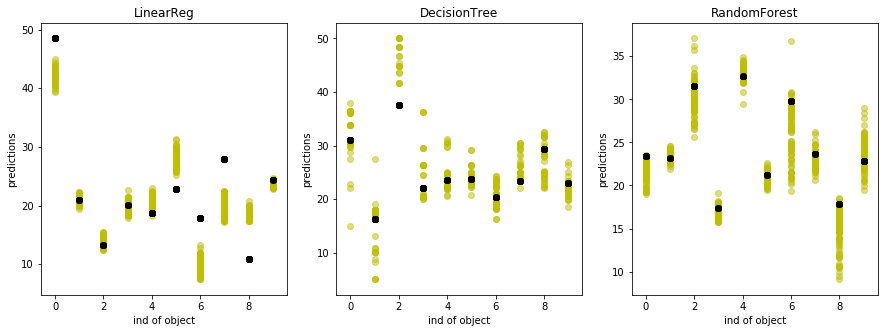

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='LinearReg')
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTree')
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='RandomForest')
plt.show()

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Вспомним, что смещение показывает насколько средний ответ алгоритма далек от идеального. А разброс указывает на чувствительность метода обучения к изменениям в выборке: насколько сильно меняется ответ в зависимости от выборки.
1. Линейная регрессия.

Результаты в задании 2 показали большое смещение и маленький разброс для линейной регрессии. Визуально видно, что, действительно ответы модели далеки от правильного, иногда он даже не попадает в точки, соответствующие ответам алгоритма. Тем не менее разброс маленький и ответы всегда близки друг к другу.

2. Решающее дерево.

Здесь все наоборот. Точки на графике "разбросаны": дисперсия большая, ответы алгоритма не всегда похожи друг на друга. Черная точка (правильный ответ) почти всегда оказывается среди желтых точек(ответах алгоритма): смещение маленькое.

3. Случайный лес.

Желтые точки (ответы алгоритма) расположены "тесно", ответы близки : маленький разброс.
Черная точка (правильный ответ) почти всегда оказывается среди желтых точек(ответах алгоритма): смещение маленькое.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [14]:
depths = np.arange(1, 11)

biases = []
variances = []

for depth in depths:
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    biases.append(b)
    variances.append(v)

In [15]:
feats = np.arange(1, X.shape[1] + 1)

biases2 = []
variances2 = []

for f in feats:
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_features=f), X, y)
    biases2.append(b)
    variances2.append(v)

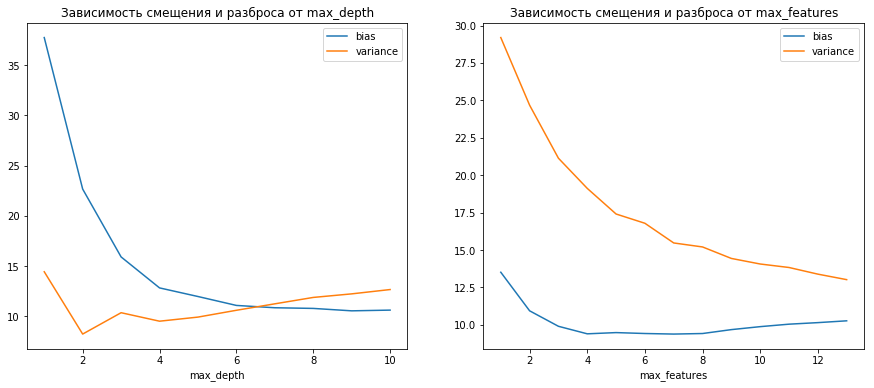

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(depths, biases, label='bias')
ax[0].plot(depths, variances, label='variance')
ax[0].set_xlabel('max_depth')
ax[0].set_title('Зависимость смещения и разброса от max_depth')
ax[0].legend()

ax[1].plot(feats, biases2, label='bias')
ax[1].plot(feats, variances2, label='variance')
ax[1].set_xlabel('max_features')
ax[1].set_title('Зависимость смещения и разброса от max_features')
ax[1].legend()

plt.show()

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [38]:
n_estimators = 2 ** np.arange(1, 10)

biases = []
variances = []

for est in n_estimators:
    b, v, _ = compute_biase_variance(RandomForestRegressor(n_estimators=est), X, y, num_runs=100)
    biases.append(b)
    variances.append(v)

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

biases2 = []
variances2 = []

for est in n_estimators:
    b, v, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=est), X, y, num_runs=100)
    biases2.append(b)
    variances2.append(v)

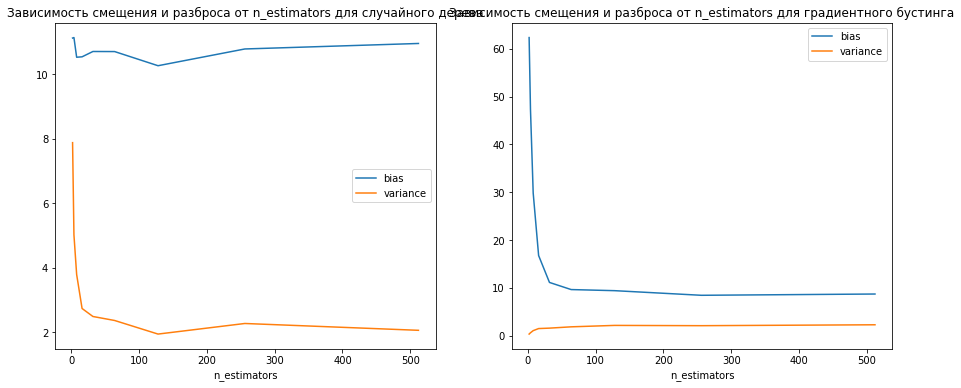

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(n_estimators, biases, label='bias')
ax[0].plot(n_estimators, variances, label='variance')
ax[0].set_xlabel('n_estimators')
ax[0].set_title('Зависимость смещения и разброса от n_estimators для случайного дерева')
ax[0].legend()

ax[1].plot(n_estimators, biases2, label='bias')
ax[1].plot(n_estimators, variances2, label='variance')
ax[1].set_xlabel('n_estimators')
ax[1].set_title('Зависимость смещения и разброса от n_estimators для градиентного бустинга')
ax[1].legend()

plt.show()

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1. Решающее дерево

    а. С увеличением глубины смещение уменьшается, разброс увеличивается. То есть можно сказать, что с увеличеним глубины дерево подстраивается под выборку и в итоге переобучается.
    
    б. С увеличением количества рассматриваемых признаков, разброс уменьшается, смещение тоже, но до некоторого момента, а потом приходит к переобучению.
    
    Т.е. можно сделать вывод, что увеличение сложности модели действительно до некоторого момента приносит хорошие результаты, главное найти ту самую грань, после которой происходит переобучение.


2. Лес и бустинг.

    а. С увеличением количества дереьвев в лесу разброс сначала стремительно падает (что вполне логично, потому что случайный лес основан на бэггинге, который, как уже говорилось выше, уменьшает разброс базовых алгоритмов), а далее остается примерно на одном уровне. Смещение же ведет себя примерно одинаково вне зависимости от количества деревьев (и это тоже логично, потому что хорошее смещение достается случайным лесам от базового алгоритма(дерева))
    
    б. При бустинге наоборот, смещение стремительно падает, а далее остается неизменным, в то время, как разброс одинаковый почти везде. Это происходит потому что каждый следующий алгоритм в бустинге целенаправленно понижает ошибку композиции, и при большом кол-ве деревьев итоговая композиция может оказаться переобученной. (по этой причине так же берут неглубокие деревья, обладающие большим смещением, но не склонные к переобучению).

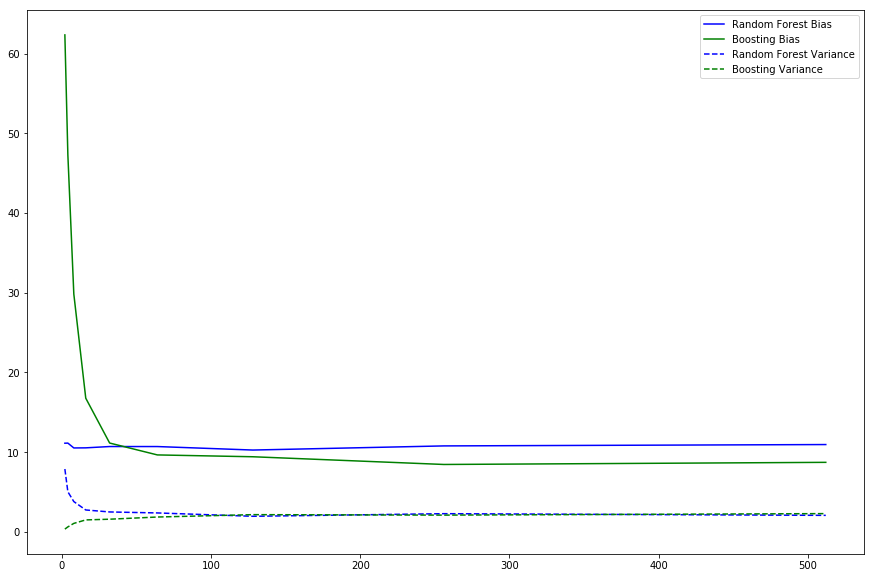

In [49]:
plt.figure(figsize=(15, 10))
plt.plot(n_estimators, biases, label ='Random Forest Bias', c='b')
plt.plot(n_estimators, biases2, label ='Boosting Bias', c = 'g')

plt.plot(n_estimators, variances, label='Random Forest Variance', c = 'b', linestyle='--')
plt.plot(n_estimators, variances2, label='Boosting Variance', c='g', linestyle='--')

plt.legend()
plt.show()